# Import and format data
## These  (until *) don't need to be run

In [4]:
import pandas as pd
# names = ['Time','ID','Data']
read_file = pd.read_csv("candump-2021-02-08_150302.log", header = None)
read_file.to_csv (r'can_data.csv', index=None)
can_data = pd.read_csv("can_data.csv")

In [5]:
can_data

,0
0,(1612792982.877603) vcan0 039#0039
1,(1612792982.878789) vcan0 095#800007F400000017
2,(1612792982.879953) vcan0 1A4#0000000800000010
3,(1612792982.880018) vcan0 1AA#7FFF000000006711
4,(1612792982.880060) vcan0 1B0#000F0000000157
...,...
845497,(1612793413.487522) vcan0 244#00000001C0
845498,(1612793413.489308) vcan0 166#D0320018
845499,(1612793413.490420) vcan0 158#0000000000000019
845500,(1612793413.490455) vcan0 161#000005500108001C


### remove vcan0

In [6]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("vcan0", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove hash

In [7]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("#", ",")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

### remove parenthesis

In [8]:
text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace("(", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

text = open("can_data.csv", "r")
text = ''.join([i for i in text]) \
    .replace(")", "")
x = open("can_data.csv","w")
x.writelines(text)
x.close()

In [9]:
can_data = pd.read_csv("can_data.csv",names = ['Time','ID','Data'])
can_data.to_csv (r'can_data.csv', index=None)
print(can_data)



                Time    ID              Data
0       0.000000e+00   NaN               NaN
1       1.612793e+09   039              0039
2       1.612793e+09   095  800007F400000017
3       1.612793e+09   1A4  0000000800000010
4       1.612793e+09   1AA  7FFF000000006711
...              ...   ...               ...
845498  1.612793e+09   244        00000001C0
845499  1.612793e+09   166          D0320018
845500  1.612793e+09   158  0000000000000019
845501  1.612793e+09   161  000005500108001C
845502  1.600000e+01   NaN               NaN

[845503 rows x 3 columns]


# *

In [ ]:
import pandas as pd
can_data = pd.read_csv("can_data.csv")
print(can_data)


In [10]:
Time = can_data['Time']
Time = Time[1:-1]
Time = Time.reset_index(drop=True)

ID = can_data['ID']
ID = ID[1:-1]
ID = ID.reset_index(drop=True)

Data = can_data['Data']
Data = Data[1:-1]
Data = Data.reset_index(drop=True)




In [11]:
import numpy as np

def delta_time(Time): # calculates the time between two subsequent messages
    delta = np.zeros((Time.size))
    for x in range(Time.size-1):

       delta[x] = Time[x+1]-Time[x]

    return delta   

delta = delta_time(Time)


In [12]:
 def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


data = convert_from_hex(Data,'dec')
id = convert_from_hex(ID,'dec')

## Normalize data

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = data.reshape(-1, 1)
#data = scaler.fit_transform(data)
id = id.reshape(-1, 1)
id = scaler.fit_transform(id)

## Visualize data

Text(0, 0.5, 'ID')

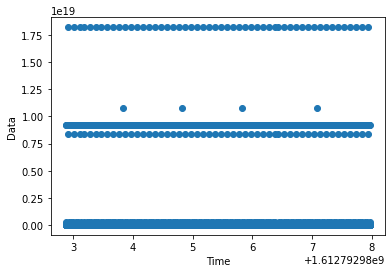

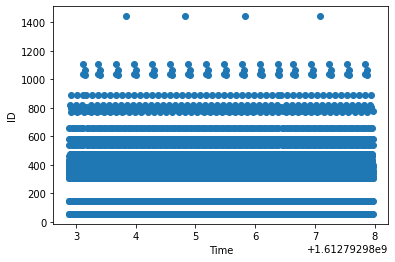

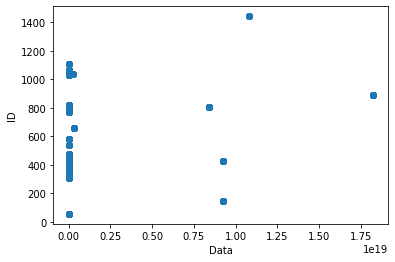

In [13]:
from matplotlib import pyplot as plt

plt.figure()
plt.plot(Time[0:10000],data[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('Data')

plt.figure()
plt.plot(Time[0:10000],id[0:10000],'o')
plt.xlabel('Time')
plt.ylabel('ID')

plt.figure()
plt.plot(data[0:10000],id[0:10000],'o')
plt.xlabel('Data')
plt.ylabel('ID')




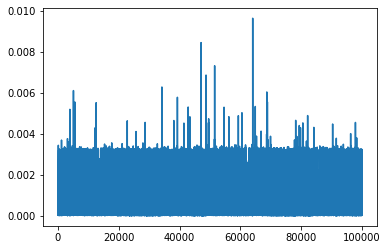

In [17]:
steps = range(Time.size)
plt.figure()
plt.plot(steps[0:100000],delta[0:100000])

In [18]:
def sort_IDs(id): # returns groups of indices of unique ids in list 

    idx_sort = np.argsort(id)
    sorted_ids = id[idx_sort]
    vals, idx_start, count = np.unique(sorted_ids, return_counts=True, return_index=True)
    indices = np.split(idx_sort, idx_start[1:])

    return indices





In [19]:
transposed_id = np.transpose(id) # not sure why it needs to be transposed but it doesn't work otherwise
indices = sort_IDs(transposed_id[0][:])




In [20]:
def get_data_stream(indices,data): # collects the unique ids with their respective data streams

    num_unique_ids = len(indices)
    all_ids = []
    for x in range(num_unique_ids):
         
         id_data = data[indices[x]]
         all_ids.append(id_data)

    return all_ids

all_id_data = get_data_stream(indices,data)  

In [22]:
 # combines each unique id with its data stream in a matrix where the ID is in the first row, and its data stream is (ordered)
 # in the column under it. (one column = ID: data1,data2,..). column length = max data length, if data doesn't fill upp all rows they are filled with nan. 
def combine_ids_data(indices,id,all_id_data):
    i = -1
    ids_and_data = np.ones((np.max([len(pi) for pi in all_id_data])+1,len(all_id_data)))*np.nan 

    for x in indices:
        i = i+ 1
        index = indices[i] 
        index = index[0] # only save first one in group
        ID = id[index]

        data_stream = all_id_data[i]
        data_stream = data_stream[:,0] 
        ids_and_data[0,i] = ID
        ids_and_data[1:len(data_stream)+1,i] = data_stream

    return ids_and_data

d = combine_ids_data(indices,id,all_id_data)

In [25]:

print(f'Number of individual IDs in the full sequence = {len(d[0,:])}')
print(f'Maximum number of data packets per ID = {np.max([len(pi) for pi in all_id_data])}')

Number of individual IDs in the full sequence = 36
Maximum number of data packets per ID = 43061


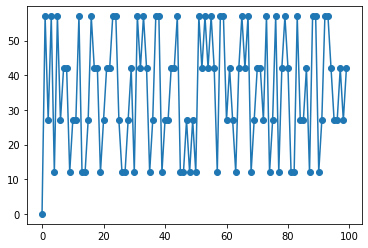

In [26]:
plt.plot(np.arange(100),d[0:100,0],'-o')

In [ ]:
# split a univariate sequence into samples
from numpy import array


def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
def remove_nans(input): # remove nans from data stream column
    input_nans = np.isnan(input) 
    not_nan = ~ input_nans
    clean_input = input[not_nan]
    return clean_input

In [ ]:
from numpy import array


def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
		# find the end of this pattern
        end_ix = i + n_steps
        end_iy = end_ix + n_steps 
		# check if we are beyond the sequence
        if end_iy > len(sequence)-1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_iy]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [ ]:
n_steps = 5
seq = remove_nans(d[:,0])   

nTrain = round(0.9*len(seq))
nTest = len(seq)-nTrain
xTrain = seq[0:nTrain]
xTest = seq[nTrain:len(seq)]

X_train, y_train = split_sequence(xTrain, n_steps)
X_test, y_test = split_sequence(xTest, n_steps)



In [ ]:
X_test.shape

In [1]:
#! pip install tensorflow
#! pip install keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [16]:

# define model (autoencoder)
n_steps = 5
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps,1)))
print(model.output_shape)
model.add(RepeatVector(n_steps))
print(model.output_shape)
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')


NameError: name 'Sequential' is not defined

# CANnolo
Will probably need to use the functional API and not the sequential model


In [ ]:
# canolo
model = Sequential()

# Encoder
model.add(Dense(256, activation='tanh', input_shape=(n_steps,1)))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences=True))

#model.add(RepeatVector(n_steps))
model.add(LSTM(128, return_sequences=True))
#model.add(RepeatVector(n_steps))

# Decoder
model.add(LSTM(128, return_sequences=True))
#model.add(RepeatVector(n_steps))
model.add(LSTM(128,return_sequences=True))
model.add(TimeDistributed(Dense(256, activation= 'sigmoid')))
model.add(TimeDistributed(Dense(1)))
#model.add(Dense(1)) # they don't mention this in the article but dimensions are wrong otherwise

#model.compile(optimizer='adam', loss='BinaryCrossentropy')
model.compile(optimizer='adam', loss='mse')
model.summary()




In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from numpy import array
# define model
inputs1 = Input(shape=(3, 1))
lstm1 = LSTM(1,return_sequences=True)(inputs1)
model = Model(inputs=inputs1, outputs=lstm1)
# define input data
data = array([0.1, 0.2, 0.3,0.4,0.5,0.6]).reshape((2,3,1))
# make and show prediction
print(model.predict(data))

In [ ]:
! pip install pydot

In [8]:
# think i need to loop over prediction or training! 

from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

# define input data
input_data = array([0.1, 0.2, 0.3,0.4,0.5,0.6]).reshape((2,3,1))
time_steps = 3
n_samples = 2
n_features = 1

# define Encoder

inputs1 = Input(shape=(time_steps,n_features))
dense1 =Dense(256, activation='tanh')(inputs1)
dropout = Dropout(0.2)(dense1)
lstm1 = LSTM(128,return_sequences=True)(dropout)
lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True)(lstm1)
states = [state_h, state_c]

Encoder = Model(inputs=inputs1, outputs=states,name="Encoder")
Encoder.summary()

# define Decoder
#decoder_input = np.zeros((n_samples,time_steps,n_features))
# for _ in range(n_samples):
#     #Want to run the decoder on one time window at a time
#     lstm3 =  LSTM(128,return_sequences=True)(decoder_input, initial_state=states)
#     lstm4 = LSTM(128,return_sequences=True)(lstm3)
#     dense2 = Dense(256, activation='sigmoid')(lstm4)
#     decoder_input = dense2
  
decoder_input = Input(shape=(time_steps,n_features))
lstm3 =  LSTM(128,return_sequences=True)(decoder_input)
lstm4 = LSTM(128,return_sequences=True)(lstm3)
dense2 = Dense(256, activation='sigmoid')(lstm4)
#decoder_input = dense2

output =  TimeDistributed(Dense(1))(dense2)
#output = dense2
#lstm3 = LSTM(128,return_sequences=True)([lstm2, state_h, state_c])
#lstm4, state_h, state_c = LSTM(128,return_sequences=True,return_state=True)(lstm3)
#dense2 = Dense(256, activation='sigmoid')(lstm4)

#EncoderDecoder = Model(inputs=inputs1, outputs=output,name="EncoderDecoder")
Decoder = Model(inputs=decoder_input, outputs=output, name="Decoder")

Decoder.summary()

#plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 3, 1)]            0         
_________________________________________________________________
dense_9 (Dense)              (None, 3, 256)            512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 3, 128)            197120    
_________________________________________________________________
lstm_13 (LSTM)               [(None, 3, 128), (None, 1 131584    
Total params: 329,216
Trainable params: 329,216
Non-trainable params: 0
_________________________________________________________________
Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output 

In [7]:

def build_model(decoder_input,time_steps,n_features):

    #define encoder
    inputs1 = Input(shape=(time_steps,n_features))
    dense1 =Dense(256, activation='tanh')(inputs1)
    dropout = Dropout(0.2)(dense1)
    lstm1 = LSTM(128,return_sequences=True)(dropout)
    lstm2, state_h, state_c = LSTM(128,return_sequences=True,return_state=True)(lstm1)
    states = [state_h, state_c]

    # define decoder  
    #d_input = [decoder_input,lstm2]
    #lstm3 =  LSTM(128,return_sequences=True)(decoder_input, initial_state = states) # need to have both decoder input and encoder output as input here
    lstm3 =  LSTM(128,return_sequences=True)(lstm2,initial_state=states)
    lstm4 = LSTM(128,return_sequences=True)(lstm3)
    dense2 = Dense(256, activation='sigmoid')(lstm4)
    output =  TimeDistributed(Dense(1))(dense2)


    EncoderDecoder = Model(inputs=inputs1, outputs=output,name="EncoderDecoder")
    EncoderDecoder.summary()

    return EncoderDecoder

#plot_model(EncoderDecoder, to_file='EncoderDecoder.png')

In [8]:
from matplotlib import pyplot
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
time_steps = 5
n_samples = 3
n_features = 1
decoder_input = np.zeros((1,time_steps,n_features))
for x in range(n_samples):

    X_train = training_data[x,:,:]
    X_test = test_data[x,:,:]
    y_train = rev_training_data[x,:,:]
    y_test = rev_test_data[x,:,:]

    model = build_model(decoder_input,time_steps,n_features)
    decoder_output = model.predict(X_train)
    decoder_input = decoder_output

    #train = model.fit(X_train, y_train, epochs=500, batch_size=15, validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[es])


Model: "EncoderDecoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 5, 256)       512         input_7[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 5, 256)       0           dense_18[0][0]                   
__________________________________________________________________________________________________
lstm_24 (LSTM)                  (None, 5, 128)       197120      dropout_6[0][0]                  
_____________________________________________________________________________________

In [2]:
from matplotlib import pyplot
# design network
# fit network
# batch size should be 128
model = EncoderDecoder
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
#for x in range(num_samples):
history = model.fit(X_train, y_train, epochs=500, batch_size=15, validation_data=(X_test, y_test), verbose=2, shuffle=False,callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

NameError: name 'EarlyStopping' is not defined

In [7]:
from numpy import array

n_steps = 5
nums = array([1,2,3,4,5,6,7,8,9,10,11,12,13,141,5])
test_nums = array([1, 1, 1, 2, 6, 2, 4, 2, 3, 8, 7, 6, 2, 3, 14])
rev_nums = nums[::-1]
rev_test_nums = test_nums[::-1]
n_features = 1
#X_test = test_nums.reshape((test_nums.shape[0], test_nums.shape[1], n_features))
#y_test = rev_test_nums.reshape((rev_test_nums.shape[0], rev_test_nums.shape[1], n_features))
#X_train = nums.reshape((nums.shape[0], nums.shape[1], n_features))
#y_train = rev_nums.reshape((rev_nums.shape[0], rev_nums.shape[1], n_features))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# nums = nums.reshape(-1, 1)
# rev_test_nums = rev_test_nums.reshape(-1,1)
# test_nums = test_nums.reshape(-1,1)
# rev_nums = rev_nums.reshape(-1,1)

# nums = scaler.fit_transform(nums)
# rev_nums = scaler.fit_transform(rev_nums)

# test_nums = scaler.fit_transform(test_nums)
# rev_test_nums = scaler.fit_transform(rev_test_nums)

X_test = test_nums.reshape((3, n_steps, n_features))
y_test = rev_test_nums.reshape((3, n_steps, n_features))
X_train = nums.reshape((3, n_steps, n_features))
y_train = rev_nums.reshape((3, n_steps, n_features))

training_data = X_train
test_data = X_test
rev_training_data = y_train
rev_test_data = y_test

In [ ]:

# demonstrate prediction
x_input = array([1,2,3,4,5,6,7,8,9,10,11,12,13,141,5])
x_input = x_input.reshape(3,5,1)
#print(x_input)
#x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)


In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(784,))
dense = layers.Dense(64, activation="relu")
a = dense(inputs)
x = layers.Dense(64, activation="relu")(a)
outputs = layers.Dense(10)(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")
model.summary()



Model: "mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


## Anomaly signal processing

 reconstruction error is calculated using the validation set
 for each CAN ID, the reconstruction error distribution is calculated using only legitimate data
 from the validation set

Anomaly score:
$a = (e- \mu)^T \Sigma ^{-1} (e-\mu)$

In [9]:
def calc_error_parameters(y_true,y_hat): # calculates the mean and deviation of the reconstruction errors according to a gaussian dist
    all_errors = []
    for x in range(len(y_true)):
        recon_error = abs(y_true[x] - y_hat[x])
        all_errors.append(recon_error)

    mean = np.mean(all_errors) # ML estimate
    standard_deviation = np.std(all_errors) # ML estimate
    variance = standard_deviation*standard_deviation

    return standard_deviation, mean, all_errors



In [10]:
y1 = array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,5])
y2 = array([1.5,2,4,4,7,8,7,8.1,9.7,11,8,12,13,11,5])

std, mu, errors = calc_error_parameters(y1,y2)
print(f'standard deviation is {std}, mean is {mu}')

standard deviation is 1.06324451039678, mean is 0.8866666666666666


In [11]:
def normal_dist(mu,sigma,x):
  f_x = (1/(sigma*np.sqrt(2*np.pi)))*np.exp((-1/2)*((x-mu)/sigma)**2)
  return f_x


(0.0, 1.0)

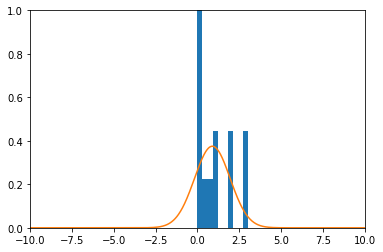

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
x = x = np.linspace(-10,10,1000)
normal = normal_dist(mu,std,x)

plt.figure()
plt.hist(errors,density=True,stacked = True,bins=10)
plt.plot(x,normal)
plt.xlim(-10, 10)
plt.ylim(0, 1)
